In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

!pip install kaggle
api_token = {"username":"your-username","key":"youre-api-key"}



In [ ]:
path='/root/.kaggle/'
file='kaggle.json'
if not (os.path.exists(path)):
  os.mkdir(path)
if not (os.path.exists('/root/.kaggle/kaggle.json')):
  with open(os.path.join(path, file), 'w+') as fp:
    print(fp) 
  !echo '{"username":"your-username","key":"youre-api-key"}' > /root/.kaggle/kaggle.json
  ! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

new-plant-diseases-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [ ]:
data_dir='new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train'
test_dir='new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid'
batch_size=128
target_size=(224,224)
epoch=100

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_train_generator=ImageDataGenerator(rescale=1./255,zoom_range=0.2,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        fill_mode='nearest')
data_valid_generator = ImageDataGenerator(rescale=1./255)
data_train=data_train_generator.flow_from_directory(directory=data_dir,
                                              shuffle=True,
                                              target_size=target_size,
                                              batch_size=batch_size)
data_test=data_valid_generator.flow_from_directory(directory=test_dir,
                                              shuffle=True,
                                              target_size=target_size,
                                              batch_size=batch_size)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
len_data=data_train.n+data_test.n
percentage_train_data= int((data_train.n/len_data)*100)
print(str(percentage_train_data) + ' %')

80 %


In [ ]:
IMG_SHAPE = target_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
class_names=data_train.class_indices

In [ ]:
image_batch, label_batch = next(iter(data_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 1280)


In [ ]:
model=tf.keras.Sequential([  
                           tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'),
                           tf.keras.layers.MaxPooling2D(2,2,padding='same'),
                           tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.MaxPooling2D(2,2,padding='same'),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(128,activation='relu'),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(64,activation='relu'),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.BatchNormalization(),
                           tf.keras.layers.Dense(38,activation='softmax')
                           ])
model.layers[0].trainable=False

In [ ]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['acc'])

In [ ]:
path_checkpoint = "model_checkpoint.h5"
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.93 and  logs.get('val_acc')>0.93):
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [ ]:
 
history = model.fit(
    data_train,
    epochs=epoch,
    validation_data=data_test,
    callbacks=[myCallback(), modelckpt_callback],
)

Epoch 1/100
550/550 [==============================] - 796s 1s/step - loss: 1.7802 - acc: 0.5312 - val_loss: 0.4508 - val_acc: 0.8625

Epoch 00001: loss improved from inf to 1.06802, saving model to model_checkpoint.h5
Epoch 2/100
550/550 [==============================] - 785s 1s/step - loss: 0.4415 - acc: 0.8656 - val_loss: 0.2975 - val_acc: 0.9050

Epoch 00002: loss improved from 1.06802 to 0.41553, saving model to model_checkpoint.h5
Epoch 3/100
550/550 [==============================] - 784s 1s/step - loss: 0.3369 - acc: 0.8946 - val_loss: 0.2327 - val_acc: 0.9235

Epoch 00003: loss improved from 0.41553 to 0.32897, saving model to model_checkpoint.h5
Epoch 4/100
550/550 [==============================] - 786s 1s/step - loss: 0.2938 - acc: 0.9089 - val_loss: 0.2297 - val_acc: 0.9227

Epoch 00004: loss improved from 0.32897 to 0.28733, saving model to model_checkpoint.h5
Epoch 5/100
550/550 [==============================] - 784s 1s/step - loss: 0.2679 - acc: 0.9155 - val_loss: 0.2

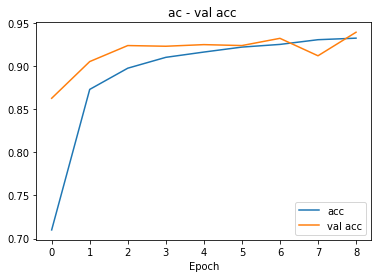

In [ ]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ac - val acc ')
plt.xlabel('Epoch')
plt.legend(['acc','val acc'], loc='best')
plt.show()

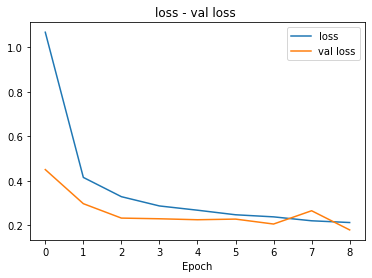

In [ ]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss - val loss ')
plt.xlabel('Epoch')
plt.legend(['loss','val loss'], loc='best')
plt.show()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpspas2q4o/assets


In [ ]:
li = list(class_names.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

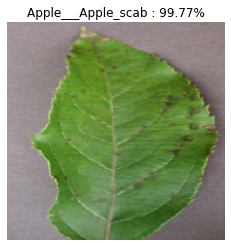

In [ ]:
b = image.load_img('/content/test/test/AppleScab1.JPG', target_size=(224, 224))
a = image.img_to_array(b)
a = np.expand_dims(a, axis=0)
a = a/255
out=model.predict(a)
percentage=np.max(out)*100
li[np.argmax(out)]

plt.figure(figsize = (4,4))
plt.imshow(b)
plt.axis('off')
plt.title(li[np.argmax(out)]+" : "+"{:.2f}".format(percentage) +'%')
plt.show()

In [ ]:
def predicttflite(image_path):
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  image_data = image.load_img(image_path, target_size=(224, 224))
  input_data = image.img_to_array(image_data)
  input_data = np.expand_dims(input_data, axis=0)
  input_data = input_data/255
  interpreter.set_tensor(input_details[0]['index'], input_data)

  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  return output_data

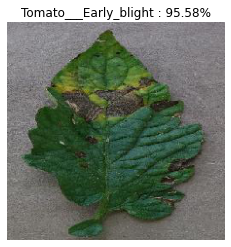

In [ ]:
test=predicttflite('/content/test/test/TomatoEarlyBlight4.JPG')
plt.figure(figsize = (4,4))
plt.imshow(image.load_img('/content/test/test/TomatoEarlyBlight4.JPG', target_size=(224, 224)))
plt.axis('off')
plt.title(li[np.argmax(test)]+" : "+"{:.2f}".format(np.max(test)*100) +'%')
plt.show()